**Author :** Rutendo F. Sigauke

**Input  :** 
1. Bidirectional calls for each sample
2. muMerged Bidirectional bed files *Paper*
3. muMerged Bidirectional bed files *Tfit and dREG*
4. Paper QC file

**Output :**

Figures

# Introduction of muMerge

The mumerge stratergy was performed in a multi-step process for both dREG and Tfit. 

1. Samples were muMerged in each paper by condition and cell type

2. All papers were merge dy cell type

3. Tfit and dREG call were combined such that when Tfit and dREG overlap, Tfit calls were used.


- See https://github.com/Dowell-Lab/bidirectionals_merged for more details.

# Load libraries

In [1]:
library(data.table) # fast loading tables
library(ggplot2)    # plotting 
library(cowplot)    # plotting pretty plots easily with ggplot2 
library(scales)     # scientific notation on axis 
library(ggvenn)     # plot venn digram
library(VennDiagram)# plot venn diagram

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: futile.logger



# Import data

## Gene annotations

### Human

In [2]:
hg38_chrom_sizes <- read.table('/scratch/Shares/dowell/genomes/hg38/hg38.chrom.sizes.unsorted')
hg38_chroms <- hg38_chrom_sizes[1:24,]
hg38_chroms$chrs <- factor(hg38_chroms$V1, levels = hg38_chroms$V1)
head(hg38_chroms, 3)

,V1,V2,chrs
,<fct>,<int>,<fct>
1,chr1,248956422,chr1
2,chr2,242193529,chr2
3,chr3,198295559,chr3


In [3]:
hg38_refseq <- read.table('/scratch/Shares/dowell/genomes/hg38/ncbi/hg38_refseq_genes.bed')
hg38_refseq_chr <- hg38_refseq[hg38_refseq$V1 %in% hg38_chroms$V1,]
dim(hg38_refseq_chr)
dim(hg38_refseq)
head(hg38_refseq_chr, 3)

[1] 28889     6

[1] 33514     6

,V1,V2,V3,V4,V5,V6
,<fct>,<int>,<int>,<fct>,<fct>,<fct>
1,chr1,11873,14409,DDX11L1,.,+
2,chr1,14361,29370,WASH7P,.,-
3,chr1,17368,17436,MIR6859-1,.,-


### Mouse

In [4]:
mm10_chrom_sizes <- read.table('/scratch/Shares/dowell/genomes/mm10/mm10.chrom.sizes')
mm10_chroms <- mm10_chrom_sizes[1:21,]
mm10_chroms$chrs <- factor(mm10_chroms$V1, levels = mm10_chroms$V1)
head(mm10_chroms,3)

,V1,V2,chrs
,<fct>,<int>,<fct>
1,chr1,195471971,chr1
2,chr2,182113224,chr2
3,chr3,160039680,chr3


In [5]:
mm10_refseq <- read.table('/scratch/Shares/dowell/genomes/mm10/ncbi/mm10_refseq_genes.bed')
mm10_refseq_chr <- mm10_refseq[mm10_refseq$V1 %in% mm10_chroms$V1,]
dim(mm10_refseq_chr)
dim(mm10_refseq)
head(mm10_refseq_chr, 3)

[1] 26182     6

[1] 26419     6

,V1,V2,V3,V4,V5,V6
,<fct>,<int>,<int>,<fct>,<fct>,<fct>
1,chr1,3199732,3671948,Xkr4,.,-
2,chr1,4115672,4409266,Rp1,.,-
3,chr1,4490927,4497426,Sox17,.,-


## Bidirectional calls

### Human

In [6]:
hg38_bidirs <- read.table("/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/hg38_tfit_dreg_bidirectionals.bed")
dim(hg38_bidirs)
head(hg38_bidirs, 3)

[1] 847521      6

,V1,V2,V3,V4,V5,V6
,<fct>,<int>,<int>,<fct>,<int>,<fct>
1,chr1,3917,4919,dreg,14,.
2,chr1,5632,6042,dreg,14,.
3,chr1,6132,6486,dreg,7,.


### Mouse

In [7]:
mm10_bidirs <- read.table("/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/mm10_tfit_dreg_bidirectionals.bed")
dim(mm10_bidirs)
head(mm10_bidirs, 3)

[1] 680735      6

,V1,V2,V3,V4,V5,V6
,<fct>,<int>,<int>,<fct>,<int>,<fct>
1,chr1,6234,6612,dreg,4,.
2,chr1,6855,7341,dreg,1,.
3,chr1,7420,8220,dreg,1,.


## Base composition for all Tfit and dREG calls

In [8]:
qc_paper <- read.table('/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/sample_metadata/20211026_paper_qc_scores.csv',
                       fill = TRUE, sep=',', header=FALSE)
colnames(qc_paper) <- c("paper","qc")
head(qc_paper, 3)

,paper,qc
,<fct>,<dbl>
1,Aeby2020decapping,1
2,Agarwal2021kdm1a,1
3,Aho2019displacement,1


In [9]:
##get paths for the tables
bc_files <- list.files(path="/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls", 
                              pattern="txt$",full.names=TRUE)
head(bc_files, 3)

[1] "/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls/hg38_dreg_gc_content.txt"
[2] "/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls/hg38_tfit_gc_content.txt"
[3] "/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls/mm10_dreg_gc_content.txt"

In [10]:
bc_list <- lapply(bc_files, data.table::fread)

In [11]:
base_composition <- do.call(rbind, bc_list)
base_composition$bidir_caller <- c(rep('dREG', 188), rep('Tfit', 189), 
                                   rep('dREG', 87), rep('Tfit', 87))
base_composition$sample_name <- substr(base_composition$id,1,nchar(base_composition$id)-5)
dim(base_composition)
head(base_composition, 3)

[1] 551   5

id,cg,at,bidir_caller,sample_name
<chr>,<dbl>,<dbl>,<chr>,<chr>
Heinaniemi2016transcription_hg38_REH_dreg,0.5694224,0.4305776,dREG,Heinaniemi2016transcription_hg38_REH
Oh2021enhancer_hg38_dreg,0.5514242,0.4485758,dREG,Oh2021enhancer_hg38
Nair2019phase_hg38_dreg,0.5411443,0.4588557,dREG,Nair2019phase_hg38


In [12]:
base_composition$bidir_caller <- as.character(lapply(lapply((strsplit(as.character(base_composition$id), 
                                                                        '_')),
                                                                         rev), `[`, 1))
base_composition$sample_name <- substr(base_composition$id,1,nchar(base_composition$id)-5)

##Tfit base compositions
base_composition_tfit <- subset(base_composition, bidir_caller=='tfit')

##dREG base composition
base_composition_dreg <- subset(base_composition, bidir_caller=='dreg')

##base composition Tfit and dREG wide
base_composition_tfit_dreg <- merge(base_composition_tfit, base_composition_dreg, by='sample_name')
base_composition_tfit_dreg$author <- as.character(lapply(strsplit(as.character(base_composition_tfit_dreg$sample_name), '_'), `[`, 1))
colnames(base_composition_tfit_dreg) <- c('sample_name','id_tfit','cg_tfit','at_tfit', 'bidir_caller_tfit',
                                         'id_dreg','cg_dreg','at_dreg', 'bidir_caller_dreg','author')
dim(base_composition_tfit_dreg)
head(base_composition_tfit_dreg)

[1] 275  10

sample_name,id_tfit,cg_tfit,at_tfit,bidir_caller_tfit,id_dreg,cg_dreg,at_dreg,bidir_caller_dreg,author
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Aeby2020decapping_mm10,Aeby2020decapping_mm10_tfit,0.5242389,0.4757611,tfit,Aeby2020decapping_mm10_dreg,0.5315533,0.4684467,dreg,Aeby2020decapping
Agarwal2021kdm1a_mm10_ESC,Agarwal2021kdm1a_mm10_ESC_tfit,0.5252982,0.4747018,tfit,Agarwal2021kdm1a_mm10_ESC_dreg,0.5365821,0.4634179,dreg,Agarwal2021kdm1a
Agarwal2021kdm1a_mm10_cortical_neuron,Agarwal2021kdm1a_mm10_cortical_neuron_tfit,0.5484798,0.4515202,tfit,Agarwal2021kdm1a_mm10_cortical_neuron_dreg,0.5844059,0.4155941,dreg,Agarwal2021kdm1a
Aho2019displacement_hg38,Aho2019displacement_hg38_tfit,0.5272918,0.4727082,tfit,Aho2019displacement_hg38_dreg,0.5540693,0.4459307,dreg,Aho2019displacement
Alexander2019imprinted_mm10_liver,Alexander2019imprinted_mm10_liver_tfit,0.5453144,0.4546856,tfit,Alexander2019imprinted_mm10_liver_dreg,0.5593769,0.4406231,dreg,Alexander2019imprinted
Alexander2019imprinted_mm10_yolk_sac,Alexander2019imprinted_mm10_yolk_sac_tfit,0.5335900,0.4664100,tfit,Alexander2019imprinted_mm10_yolk_sac_dreg,0.5424324,0.4575676,dreg,Alexander2019imprinted


In [13]:
base_composition_tfit_dreg_qc <- merge(base_composition_tfit_dreg, qc_paper, by.x='author', by.y='paper')
head(base_composition_tfit_dreg_qc, 3)

author,sample_name,id_tfit,cg_tfit,at_tfit,bidir_caller_tfit,id_dreg,cg_dreg,at_dreg,bidir_caller_dreg,qc
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Aeby2020decapping,Aeby2020decapping_mm10,Aeby2020decapping_mm10_tfit,0.5242389,0.4757611,tfit,Aeby2020decapping_mm10_dreg,0.5315533,0.4684467,dreg,1
Agarwal2021kdm1a,Agarwal2021kdm1a_mm10_ESC,Agarwal2021kdm1a_mm10_ESC_tfit,0.5252982,0.4747018,tfit,Agarwal2021kdm1a_mm10_ESC_dreg,0.5365821,0.4634179,dreg,1
Agarwal2021kdm1a,Agarwal2021kdm1a_mm10_cortical_neuron,Agarwal2021kdm1a_mm10_cortical_neuron_tfit,0.5484798,0.4515202,tfit,Agarwal2021kdm1a_mm10_cortical_neuron_dreg,0.5844059,0.4155941,dreg,1


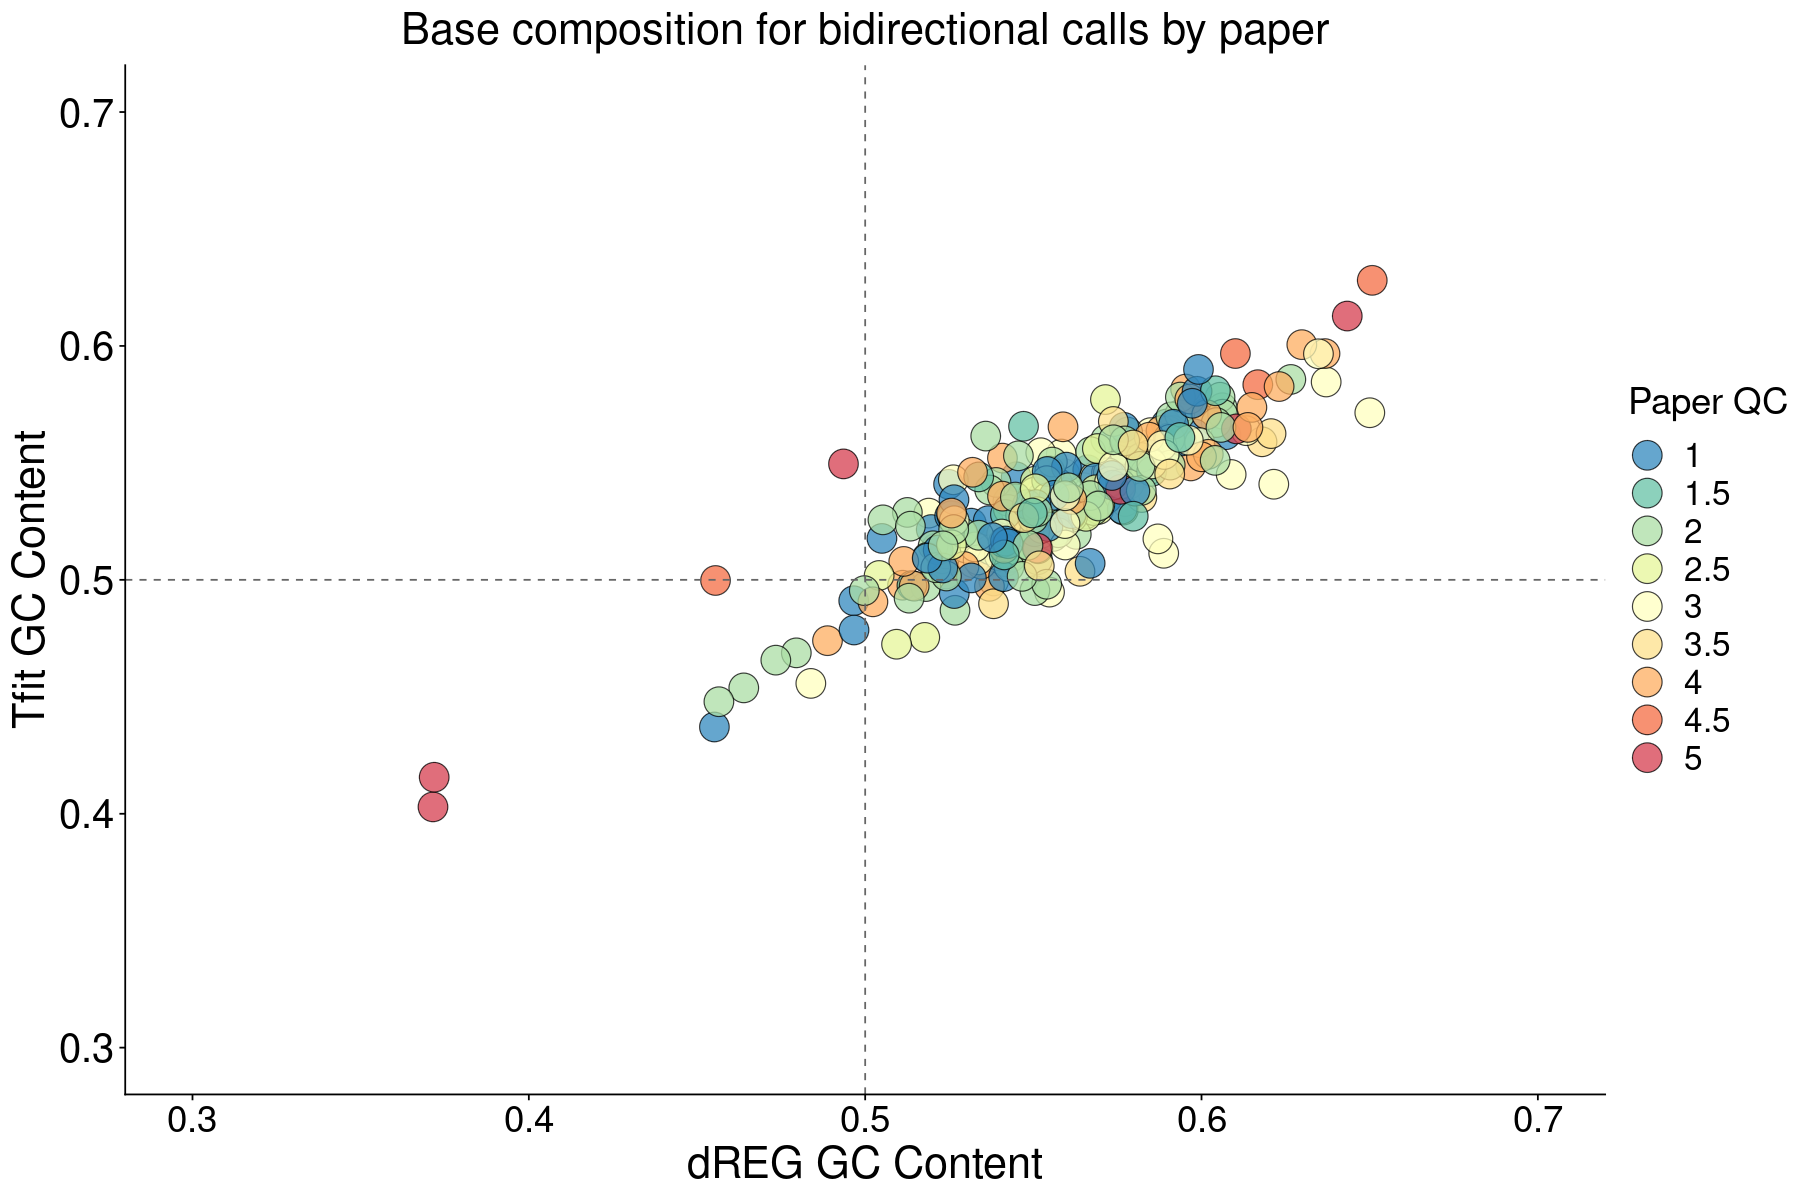

In [14]:
options(repr.plot.width=15, repr.plot.height=10)

bc1 <- ggplot(base_composition_tfit_dreg_qc, 
           aes(x=as.numeric(cg_dreg),
               y=as.numeric(cg_tfit),
              fill=as.character(qc))) + 
      geom_point(size=8,shape=21, alpha=0.75)+
    theme_cowplot() + 
    xlim(0.3,0.7) +
    ylim(0.3,0.7) +
    scale_fill_brewer(name = 'Paper QC',
                    palette = "Spectral", direction=-1) +
    labs(title = "Base composition for bidirectional calls by paper",
         x = "dREG GC Content", 
         y = "Tfit GC Content") + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "gray40") +
    geom_vline(xintercept=0.5, linetype="dashed", color = "gray40") +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "plain",
                                   size = 26),
          axis.title = element_text(size = 26), 
          axis.text = element_text(size = 24),
          axis.text.x = element_text(size = 22),
         legend.title = element_text(size = 22),
         legend.text = element_text(size = 20))

bc1 

In [15]:
ggsave(bc1, width = 15, height = 10,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/base_composition_bidirectionals.pdf", 
       bg = "transparent")

# Summaries

## Number of calls per sample

### Tfit

In [16]:
dbnascent <- list.dirs(path = '/Shares/dbnascent',
          full.names = TRUE, 
          recursive = FALSE
             )

dbnascent_paths <- paste0(dbnascent, "/tfit")
length(dbnascent_paths)

[1] 291

In [17]:
tfit_summary_paths <- unlist(lapply(dbnascent_paths, 
                              list.files, 
                              pattern="_cov_filtered.bed", 
                              full.names=TRUE))

length(dbnascent_paths)
length(tfit_summary_paths)

[1] 291

[1] 2189

In [18]:
tfit_calls <- lapply(tfit_summary_paths, data.table::fread)
length(tfit_calls)

[1] 2189

In [19]:
tfit_counts <- lapply(tfit_calls, nrow)
head(tfit_counts)

[[1]]
[1] 79544

[[2]]
[1] 63792

[[3]]
[1] 69002

[[4]]
[1] 72314

[[5]]
[1] 22816

[[6]]
[1] 49038

In [20]:
tfit_call_summary <- data.table(tfit_summary_paths, tfit_counts)
tfit_call_summary$caller <- "Tfit"
head(tfit_call_summary)

tfit_summary_paths,tfit_counts,caller
<chr>,<list>,<chr>
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364243.sorted_split_bidir_cov_filtered.bed,79544,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364244.sorted_split_bidir_cov_filtered.bed,63792,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364245.sorted_split_bidir_cov_filtered.bed,69002,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364246.sorted_split_bidir_cov_filtered.bed,72314,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364247.sorted_split_bidir_cov_filtered.bed,22816,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364248.sorted_split_bidir_cov_filtered.bed,49038,Tfit


### dREG

In [21]:
dbnascent_dreg_paths <- paste0(dbnascent, "/dreg")
length(dbnascent_dreg_paths)

[1] 291

In [22]:
dreg_summary_paths <- unlist(lapply(dbnascent_dreg_paths, 
                              list.files, 
                              pattern="covfiltered.bed", 
                              full.names=TRUE))

length(dreg_summary_paths)

[1] 2224

In [23]:
dreg_calls <- lapply(dreg_summary_paths, data.table::fread)
length(dreg_calls) #Note, some papers did not run successfully with dREG

Warning message in FUN(X[[i]], ...):
“File '/Shares/dbnascent/Nguyen2020dichotomous/dreg/SRR10486676.sorted.dREG.full.covfiltered.bed' has size 0. Returning a NULL data.table.”
Warning message in FUN(X[[i]], ...):
“File '/Shares/dbnascent/Zhang2019fundamental/dreg/SRR9961461.sorted.dREG.full.covfiltered.bed' has size 0. Returning a NULL data.table.”


[1] 2224

In [24]:
dreg_counts <- lapply(dreg_calls, nrow)
head(dreg_counts)

[[1]]
[1] 63678

[[2]]
[1] 51616

[[3]]
[1] 50841

[[4]]
[1] 57441

[[5]]
[1] 21882

[[6]]
[1] 39489

In [25]:
dreg_call_summary <- data.table(dreg_summary_paths, dreg_counts)
dreg_call_summary$caller <- "dREG"
head(dreg_call_summary)

dreg_summary_paths,dreg_counts,caller
<chr>,<list>,<chr>
/Shares/dbnascent/Aeby2020decapping/dreg/SRR8364243.sorted.dREG.full.covfiltered.bed,63678,dREG
/Shares/dbnascent/Aeby2020decapping/dreg/SRR8364244.sorted.dREG.full.covfiltered.bed,51616,dREG
/Shares/dbnascent/Aeby2020decapping/dreg/SRR8364245.sorted.dREG.full.covfiltered.bed,50841,dREG
/Shares/dbnascent/Aeby2020decapping/dreg/SRR8364246.sorted.dREG.full.covfiltered.bed,57441,dREG
/Shares/dbnascent/Aeby2020decapping/dreg/SRR8364247.sorted.dREG.full.covfiltered.bed,21882,dREG
/Shares/dbnascent/Aeby2020decapping/dreg/SRR8364248.sorted.dREG.full.covfiltered.bed,39489,dREG


### Plot number of calls per paper

In [26]:
call_summary <- rbind(tfit_call_summary, 
                      dreg_call_summary, 
                      use.names=FALSE)
dim(call_summary)
head(call_summary)

[1] 4413    3

tfit_summary_paths,tfit_counts,caller
<chr>,<list>,<chr>
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364243.sorted_split_bidir_cov_filtered.bed,79544,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364244.sorted_split_bidir_cov_filtered.bed,63792,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364245.sorted_split_bidir_cov_filtered.bed,69002,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364246.sorted_split_bidir_cov_filtered.bed,72314,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364247.sorted_split_bidir_cov_filtered.bed,22816,Tfit
/Shares/dbnascent/Aeby2020decapping/tfit/SRR8364248.sorted_split_bidir_cov_filtered.bed,49038,Tfit


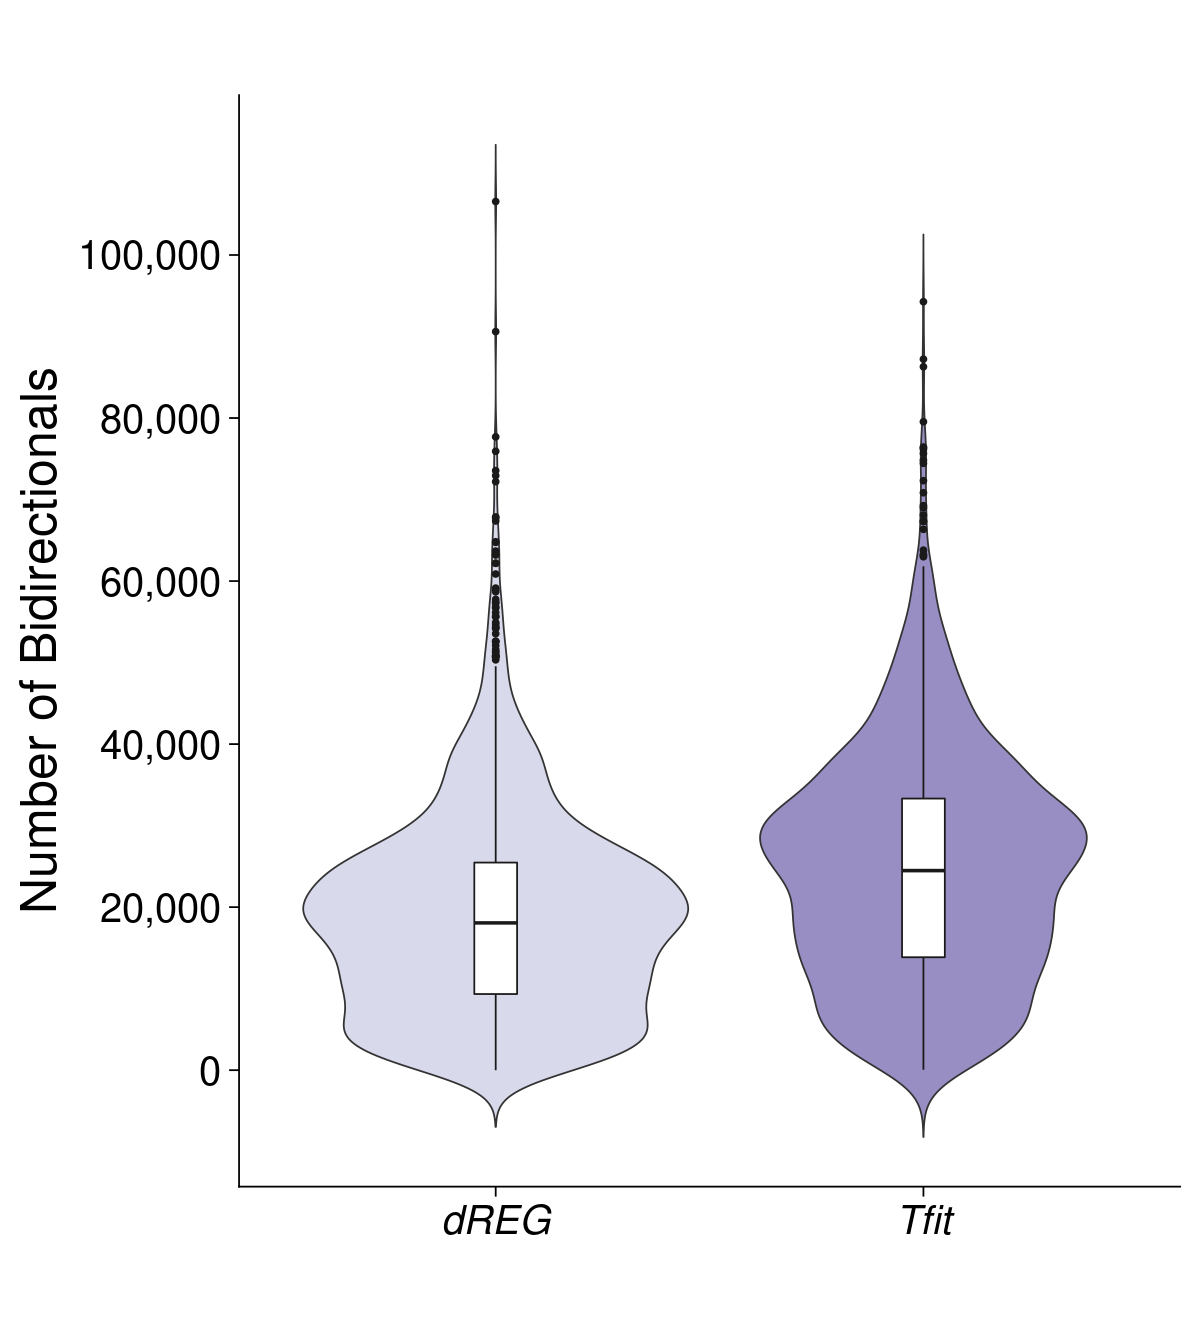

In [27]:
options(repr.plot.width=10, repr.plot.height=11)
bidir_calls <- ggplot(call_summary,
                     aes(x=caller, 
                          y=as.numeric(tfit_counts),
                         fill=caller)) + 
geom_violin(trim=FALSE,position = position_dodge(0.9)) +
geom_boxplot(width=0.1, color='grey10', fill='white',position = position_dodge(0.9)) + 
ggtitle(" ") +
ylab('Number of Bidirectionals') + 
xlab(' ') + 
scale_fill_manual(name=' ',
                  values = c("#d8daeb","#998ec3"))+ 
theme_cowplot(24) +
scale_y_continuous(
                    breaks= c(0, 20000,40000,
                              60000,80000,
                              100000, 120000),
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, face = "bold"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 24,face="italic"),
      axis.text.y = element_text(size = 24),
     legend.title = element_text(size = 28),
     legend.text = element_text(size = 26),
     legend.position = "none") 

bidir_calls

In [28]:
ggsave(bidir_calls, width = 10, height = 11,
       filename = "/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/bidir_calls_dreg_tfit_counts.pdf", 
       bg = "transparent")

ggsave(bidir_calls, width = 10, height = 11,
       filename = "/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/bidir_calls_dreg_tfit_counts.png", 
       bg = "transparent")

## Overlap between Tfit and dREG `muMerge` output

### Human

In [29]:
hg38_bidirs$bidir_id <- paste0(hg38_bidirs$V1,":",
                              hg38_bidirs$V2,"-",
                              hg38_bidirs$V3)
head(hg38_bidirs)

,V1,V2,V3,V4,V5,V6,bidir_id
,<fct>,<int>,<int>,<fct>,<int>,<fct>,<chr>
1,chr1,3917,4919,dreg,14,.,chr1:3917-4919
2,chr1,5632,6042,dreg,14,.,chr1:5632-6042
3,chr1,6132,6486,dreg,7,.,chr1:6132-6486
4,chr1,7207,7841,dreg,7,.,chr1:7207-7841
5,chr1,10945,11371,"tfit,dreg",1,.,chr1:10945-11371
6,chr1,12182,12456,"tfit,dreg",1,.,chr1:12182-12456


In [30]:
unique(hg38_bidirs$V4)

[1] dreg           tfit,dreg      tfit           tfit|tfit,dreg
Levels: dreg tfit tfit,dreg tfit|tfit,dreg

In [31]:
hg38_bidir_regions <- list(
  Tfit = subset(hg38_bidirs, V4=='tfit' | V4=='tfit,dreg' | V4=='tfit|tfit,dreg')$bidir_id, 
  dREG = subset(hg38_bidirs, V4=='dreg' | V4=='tfit,dreg' | V4=='tfit|tfit,dreg')$bidir_id 
  )

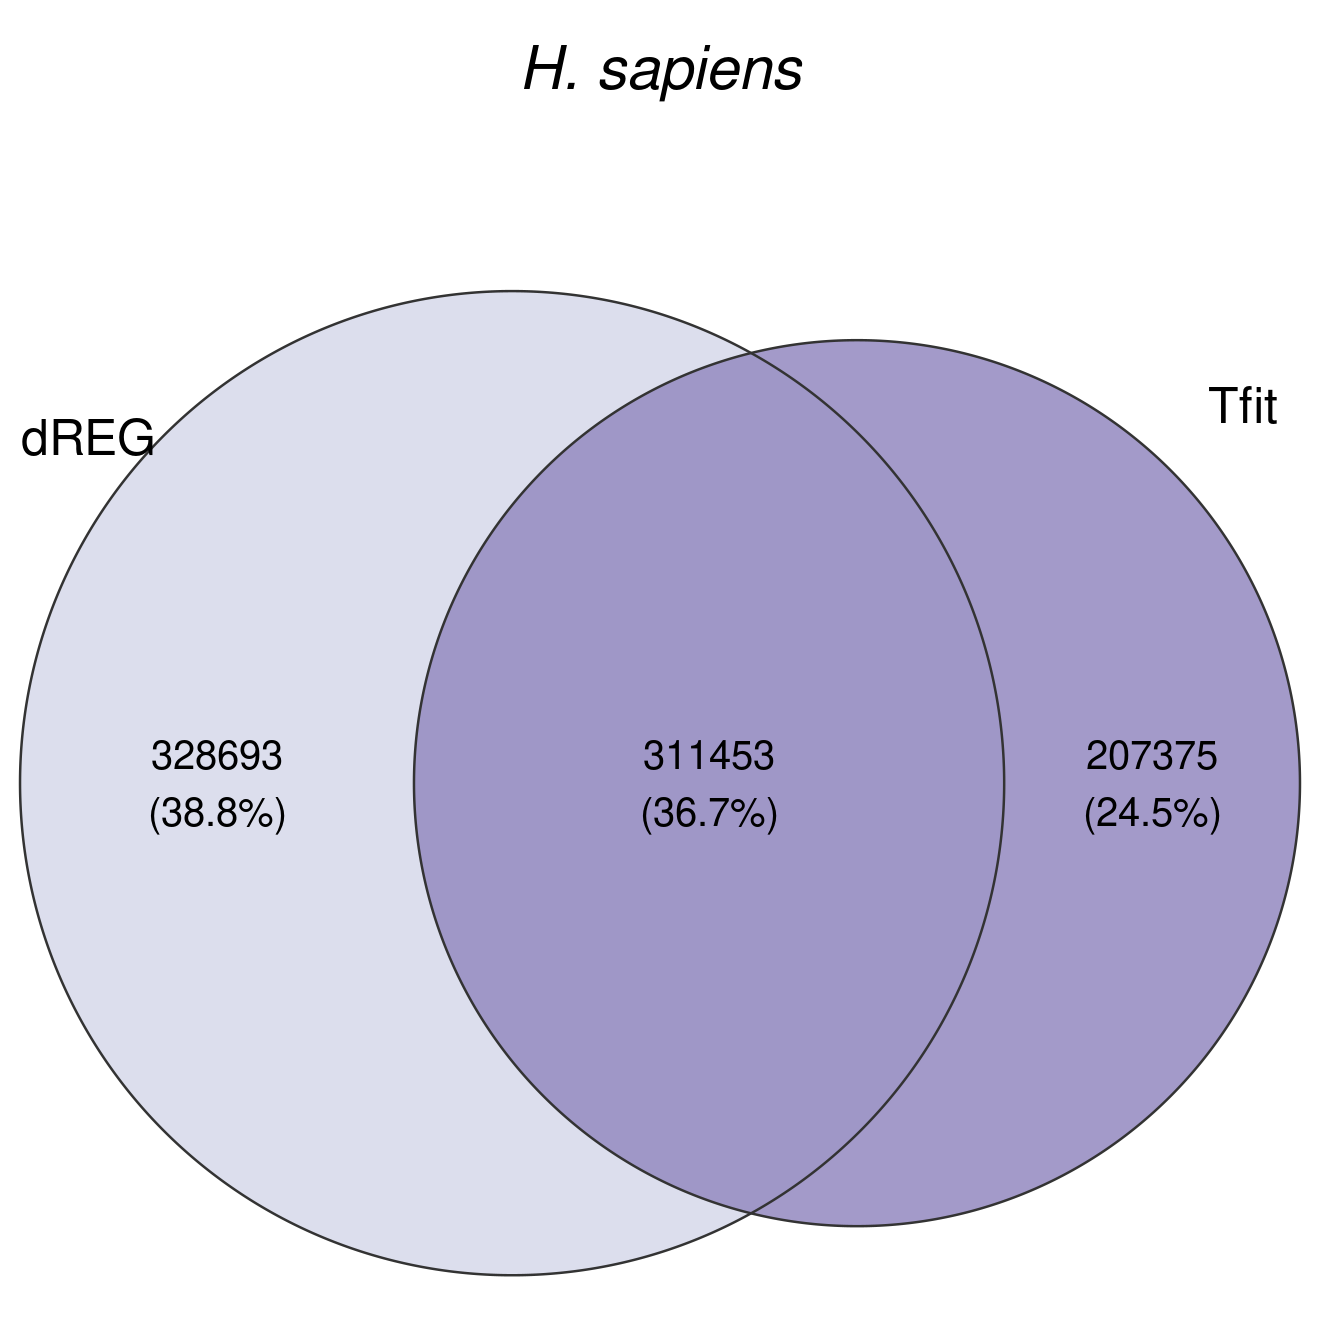

In [32]:
options(repr.plot.width=11, repr.plot.height=11)

hg38_venn0 <- venn.diagram(hg38_bidir_regions,
                           filename = NULL,
                           main="H. sapiens",
                           main.cex = 3,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.90,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb"),#'#4dac26','#d01c8b'),
                           cex = rep(2, 3),
                           cat.cex = rep(2.5, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(0.5, -19), c(0.5, -19)))

grid.draw(hg38_venn0);
grid.newpage()

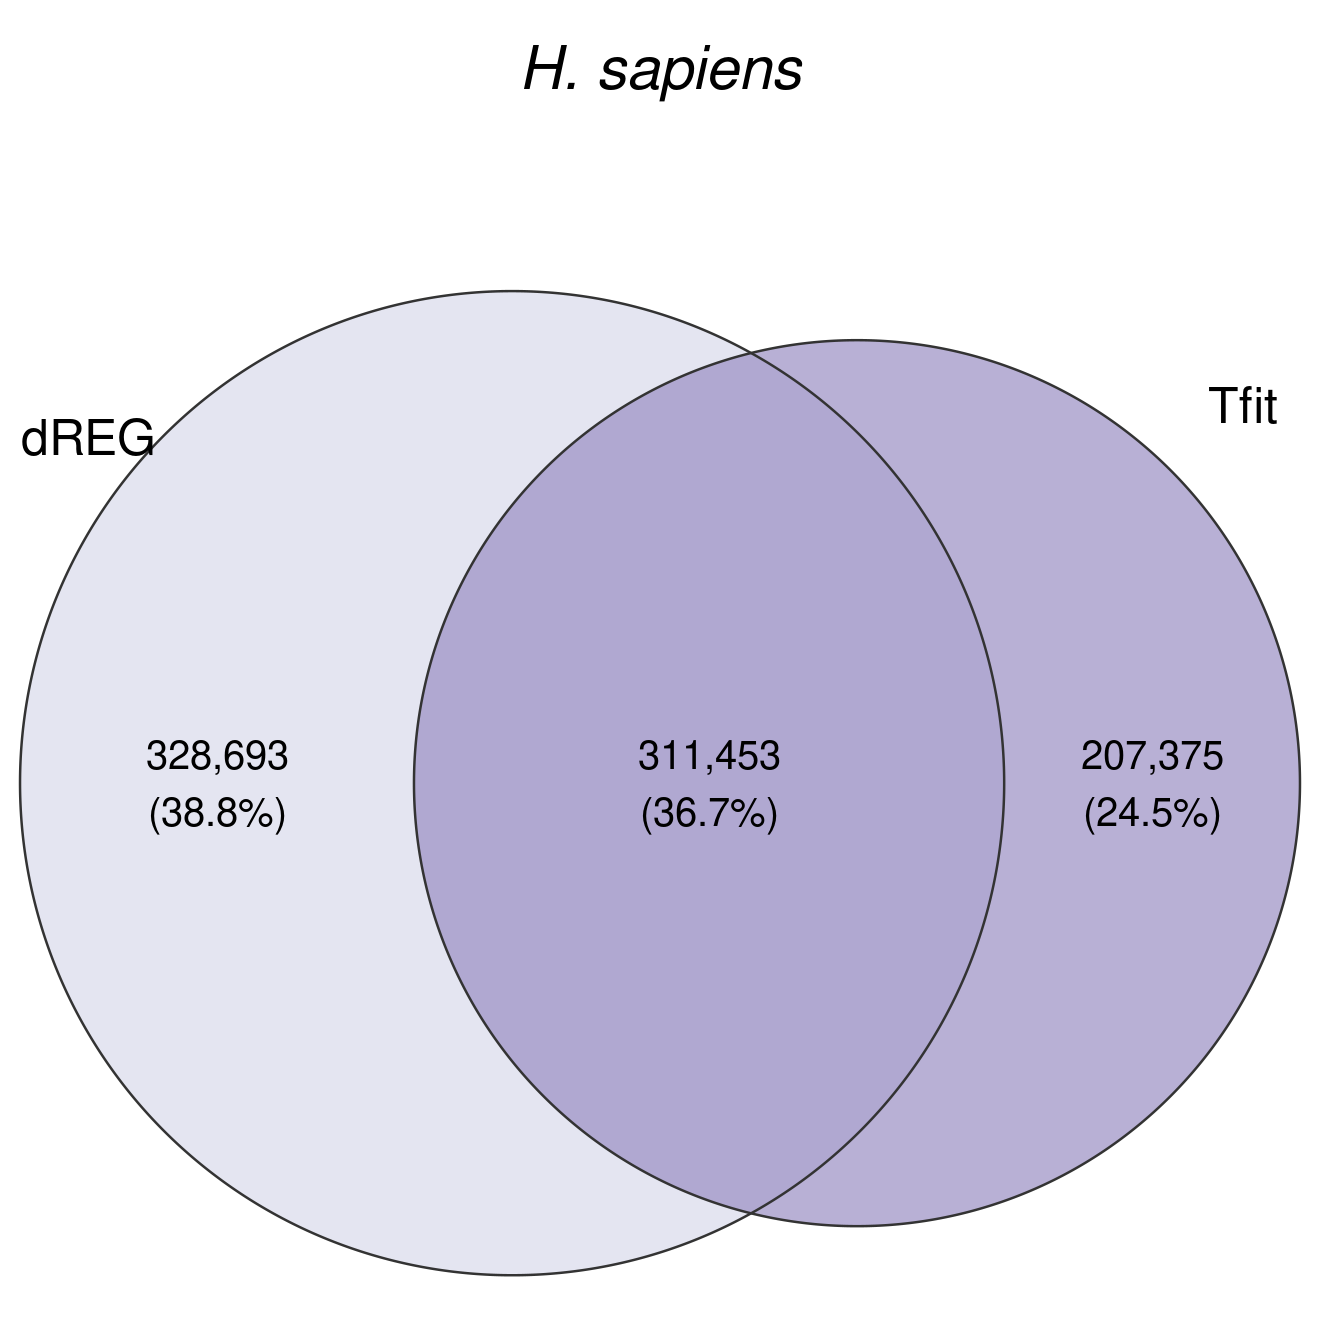

In [33]:
options(repr.plot.width=11, repr.plot.height=11)

hg38_venn <- venn.diagram(hg38_bidir_regions,
                           filename = NULL,
                           main="H. sapiens",
                           main.cex = 3,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.70,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb"), #c('#4dac26','#d01c8b'),
                           cex = rep(2, 3),
                           cat.cex = rep(2.5, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(0.5, -19), c(0.5, -19)))

hg38_venn[[5]][["label"]] <- "328,693\n(38.8%)"
hg38_venn[[6]][["label"]] <- "207,375\n(24.5%)"
hg38_venn[[7]][["label"]] <- "311,453\n(36.7%)"

grid.draw(hg38_venn);
grid.newpage()

In [34]:
ggsave(hg38_venn, 
       file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/hg38_bidir_venn.svg",
       device = "svg")
ggsave(hg38_venn, width = 6, height = 6,
       file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/hg38_bidir_venn.pdf",
       bg = "transparent")

Saving 6.67 x 6.67 in image



### Mouse

In [35]:
mm10_bidirs$bidir_id <- paste0(mm10_bidirs$V1,":",
                              mm10_bidirs$V2,"-",
                              mm10_bidirs$V3)
head(mm10_bidirs)

,V1,V2,V3,V4,V5,V6,bidir_id
,<fct>,<int>,<int>,<fct>,<int>,<fct>,<chr>
1,chr1,6234,6612,dreg,4,.,chr1:6234-6612
2,chr1,6855,7341,dreg,1,.,chr1:6855-7341
3,chr1,7420,8220,dreg,1,.,chr1:7420-8220
4,chr1,8419,8749,dreg,1,.,chr1:8419-8749
5,chr1,8885,9199,dreg,1,.,chr1:8885-9199
6,chr1,9679,9991,dreg,1,.,chr1:9679-9991


In [36]:
unique(mm10_bidirs$V4)

[1] dreg           tfit           tfit,dreg      tfit|tfit,dreg
Levels: dreg tfit tfit,dreg tfit|tfit,dreg

In [37]:
mm10_bidir_regions <- list(
  Tfit = subset(mm10_bidirs, V4=='tfit' | V4=='tfit,dreg' | V4=='tfit|tfit,dreg')$bidir_id, 
  dREG = subset(mm10_bidirs, V4=='dreg' | V4=='tfit,dreg' | V4=='tfit|tfit,dreg')$bidir_id 
  )

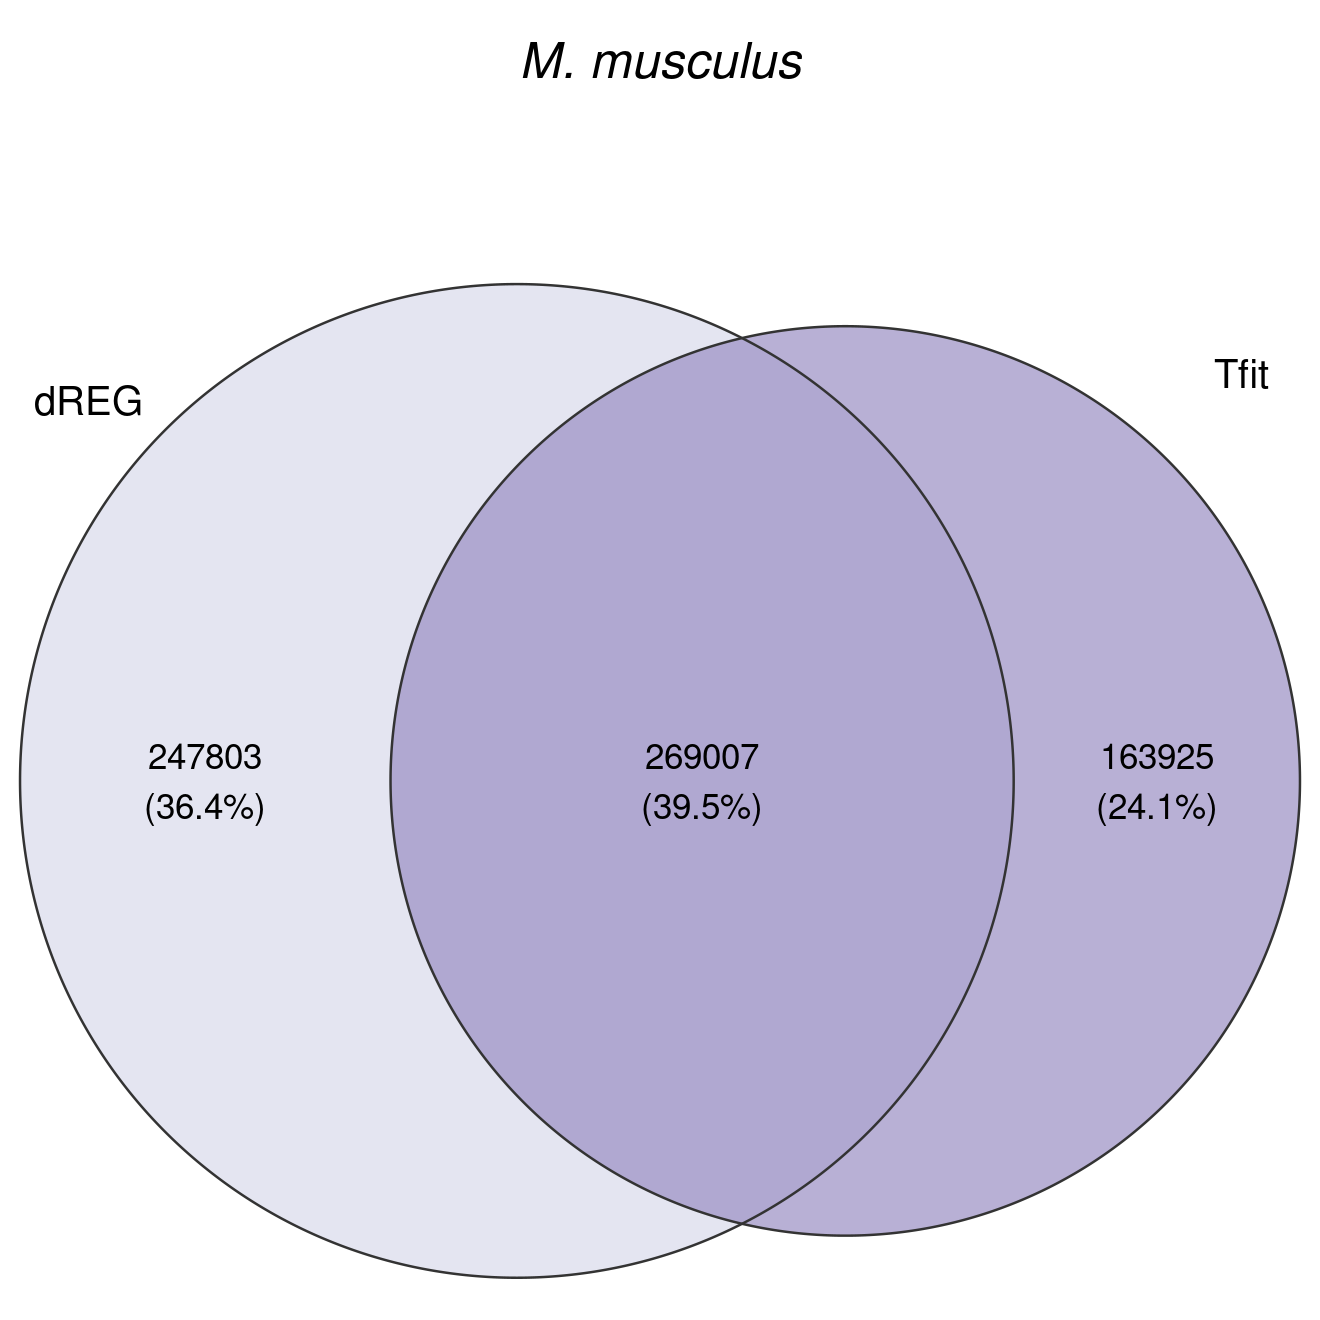

In [38]:
options(repr.plot.width=11, repr.plot.height=11)

mm10_venn0 <- venn.diagram(mm10_bidir_regions,
                           filename = NULL,
                           main="M. musculus",
                           main.cex = 2.5,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.70,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb") , 
                           cex = rep(1.75, 3),
                           cat.cex = rep(2, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(0.5, -25), c(0.5, -25)))


grid.draw(mm10_venn0);
grid.newpage()

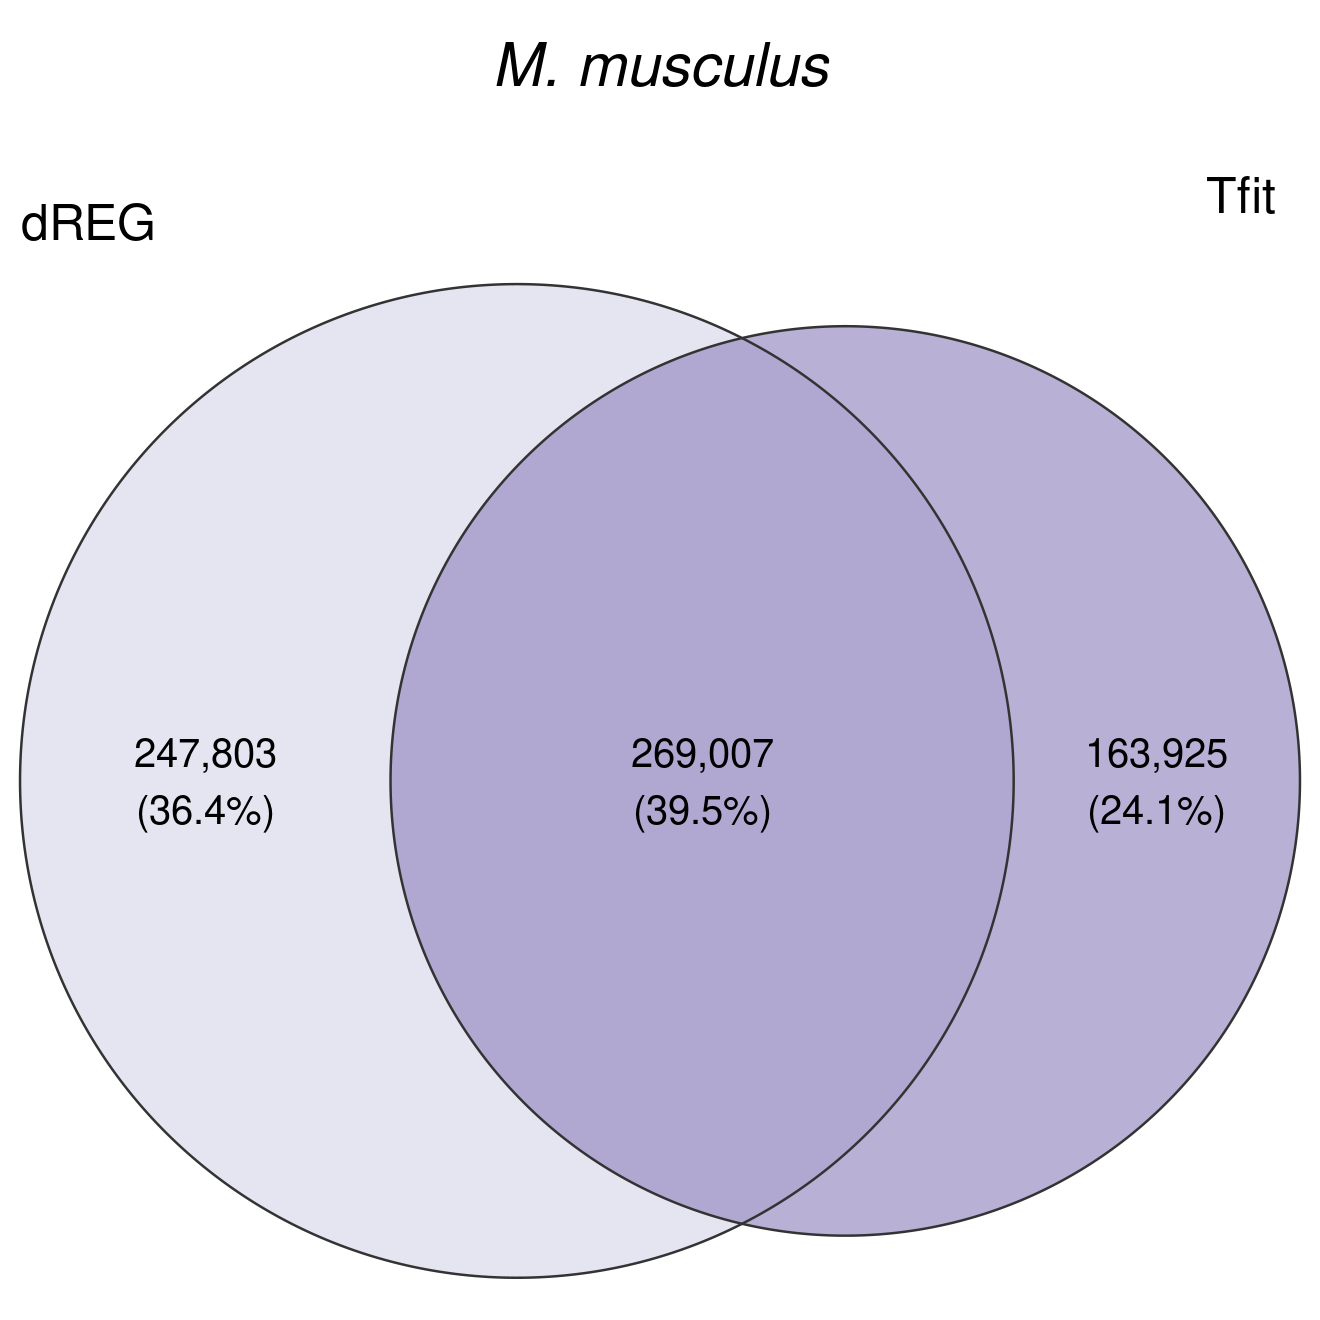

In [39]:
options(repr.plot.width=11, repr.plot.height=11)

mm10_venn <- venn.diagram(mm10_bidir_regions,
                           filename = NULL,
                           main="M. musculus",
                           main.cex = 3,
                          main.fontfamily = 'sans',
                          fontfamily = 'sans',
                          main.fontface = 'italic',
                          alpha = 0.70,
                            print.mode=c("raw","percent"),
                           col = rep("gray20",2),
                           fill = c("#998ec3","#d8daeb"), #c('#4dac26','#d01c8b'),
                           cex = rep(2, 3),
                           cat.cex = rep(2.5, 2),
                         cat.fontfamily = 'sans',
                         cat.just=list(c(0.5, -25), c(0.5, -25)))

mm10_venn[[5]][["label"]] <- "247,803\n(36.4%)"
mm10_venn[[6]][["label"]] <- "163,925\n(24.1%)"
mm10_venn[[7]][["label"]] <- "269,007\n(39.5%)"

grid.draw(mm10_venn);
grid.newpage()

In [40]:
ggsave(mm10_venn, 
       file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/mm10_bidir_venn.svg", 
       device = "svg")

ggsave(mm10_venn, width = 6, height = 6,
       file="/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/mm10_bidir_venn.pdf",
       bg = "transparent")

Saving 6.67 x 6.67 in image



## Where do the bidirectional transcripts fall in genome

### Human

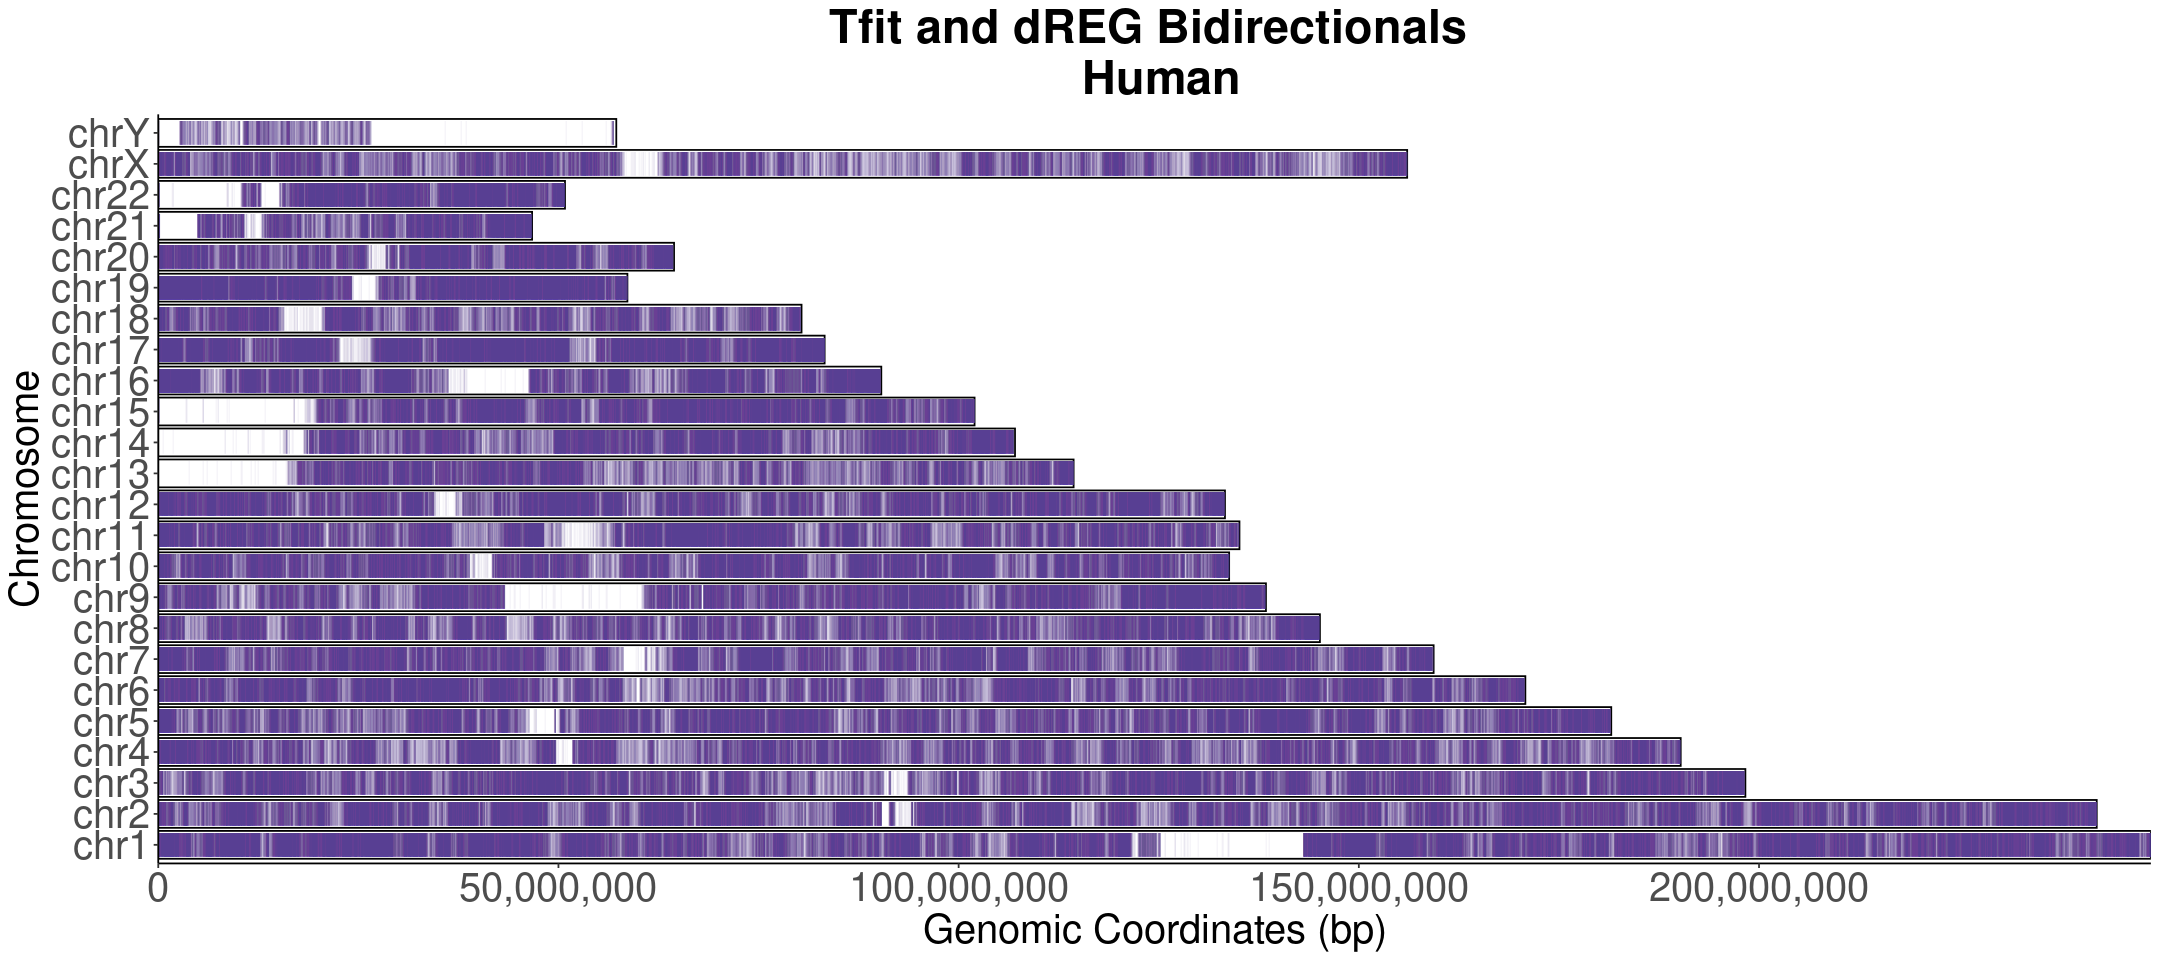

In [41]:
options(repr.plot.width=18, repr.plot.height=8)

hg38_bidirs_plot <- ggplot(data=hg38_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = hg38_bidirs,
           aes(y = V1, x = V2), 
           shape=124, 
           color='#5e3c99',#'orange',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("Tfit and dREG Bidirectionals \n Human") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

hg38_bidirs_plot

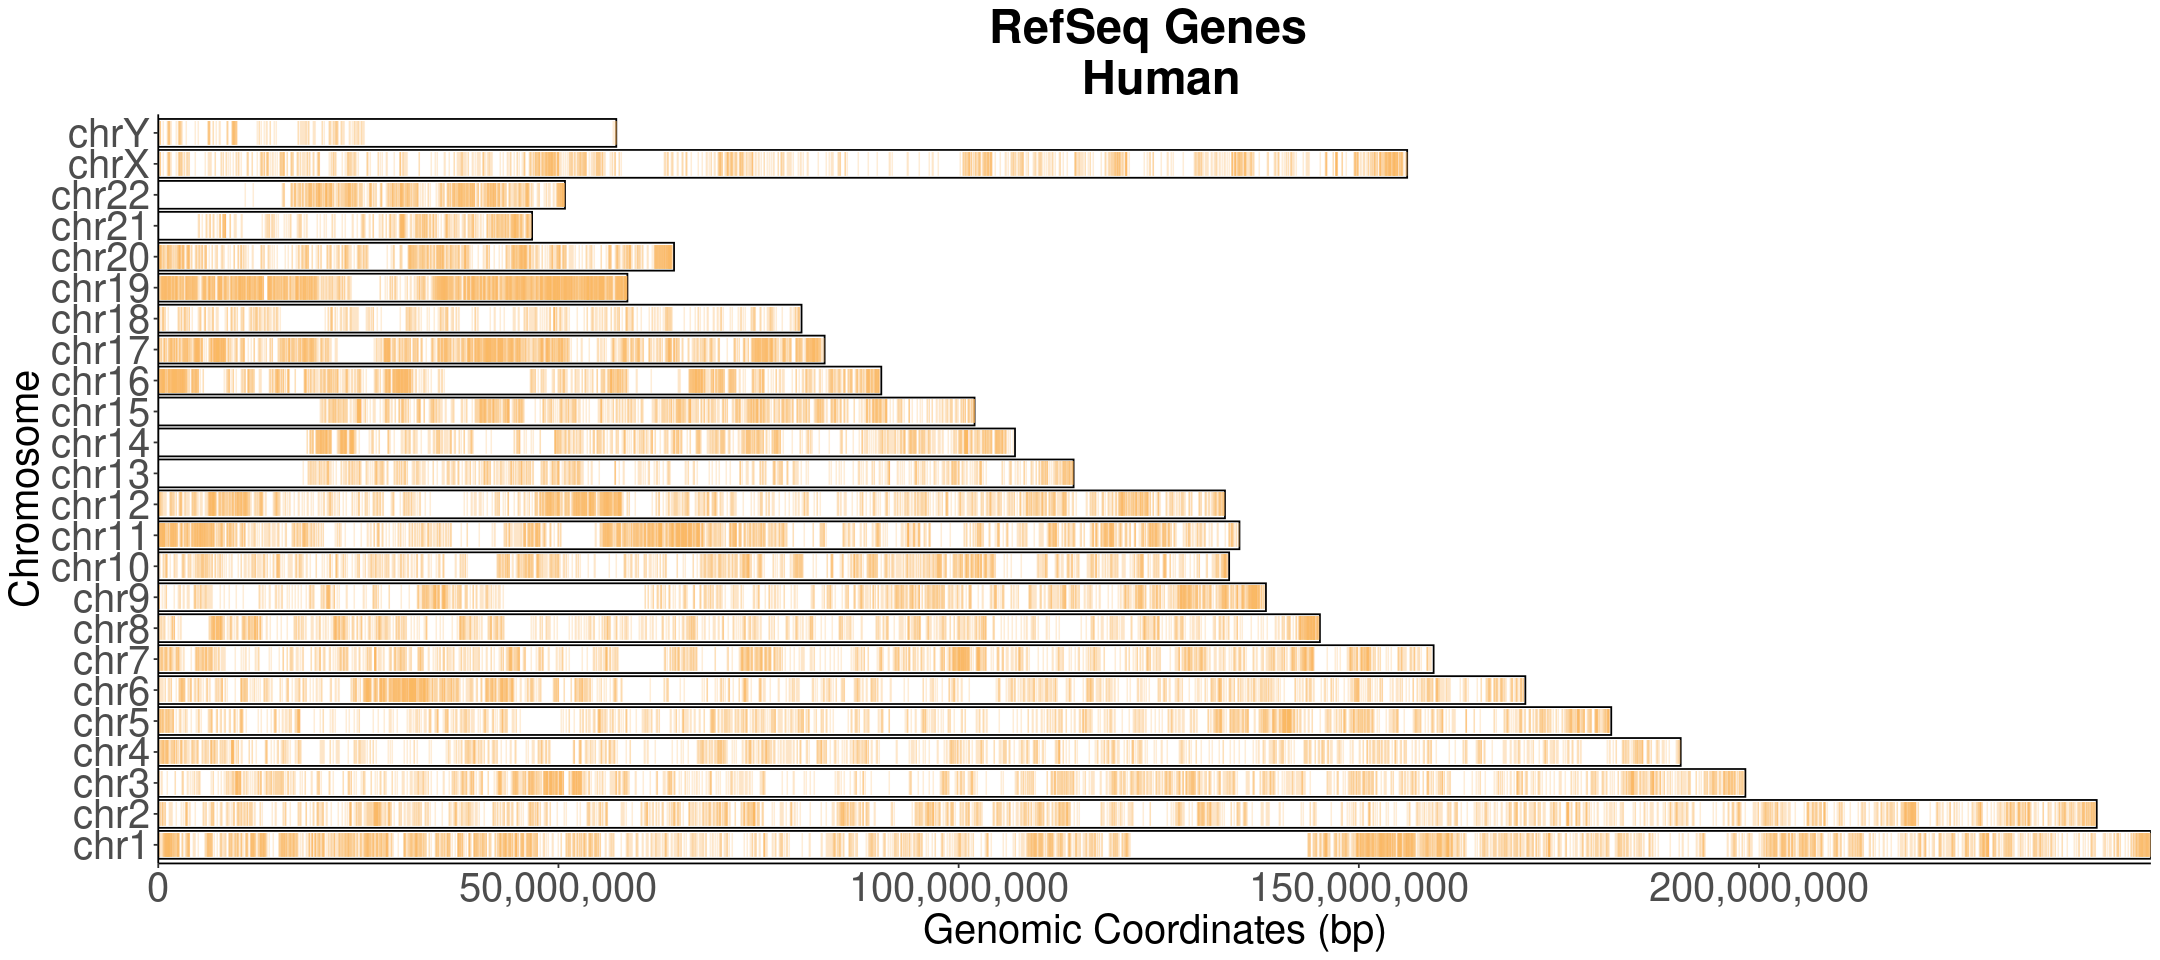

In [42]:
options(repr.plot.width=18, repr.plot.height=8)

hg38_refseq_plot <- ggplot(data=hg38_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = hg38_refseq_chr,
           aes(y = V1, x = V2), 
           shape=124, 
           color= '#fdb863',#'gray40',
           size=5, 
           alpha=0.25) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("RefSeq Genes \n Human") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

hg38_refseq_plot

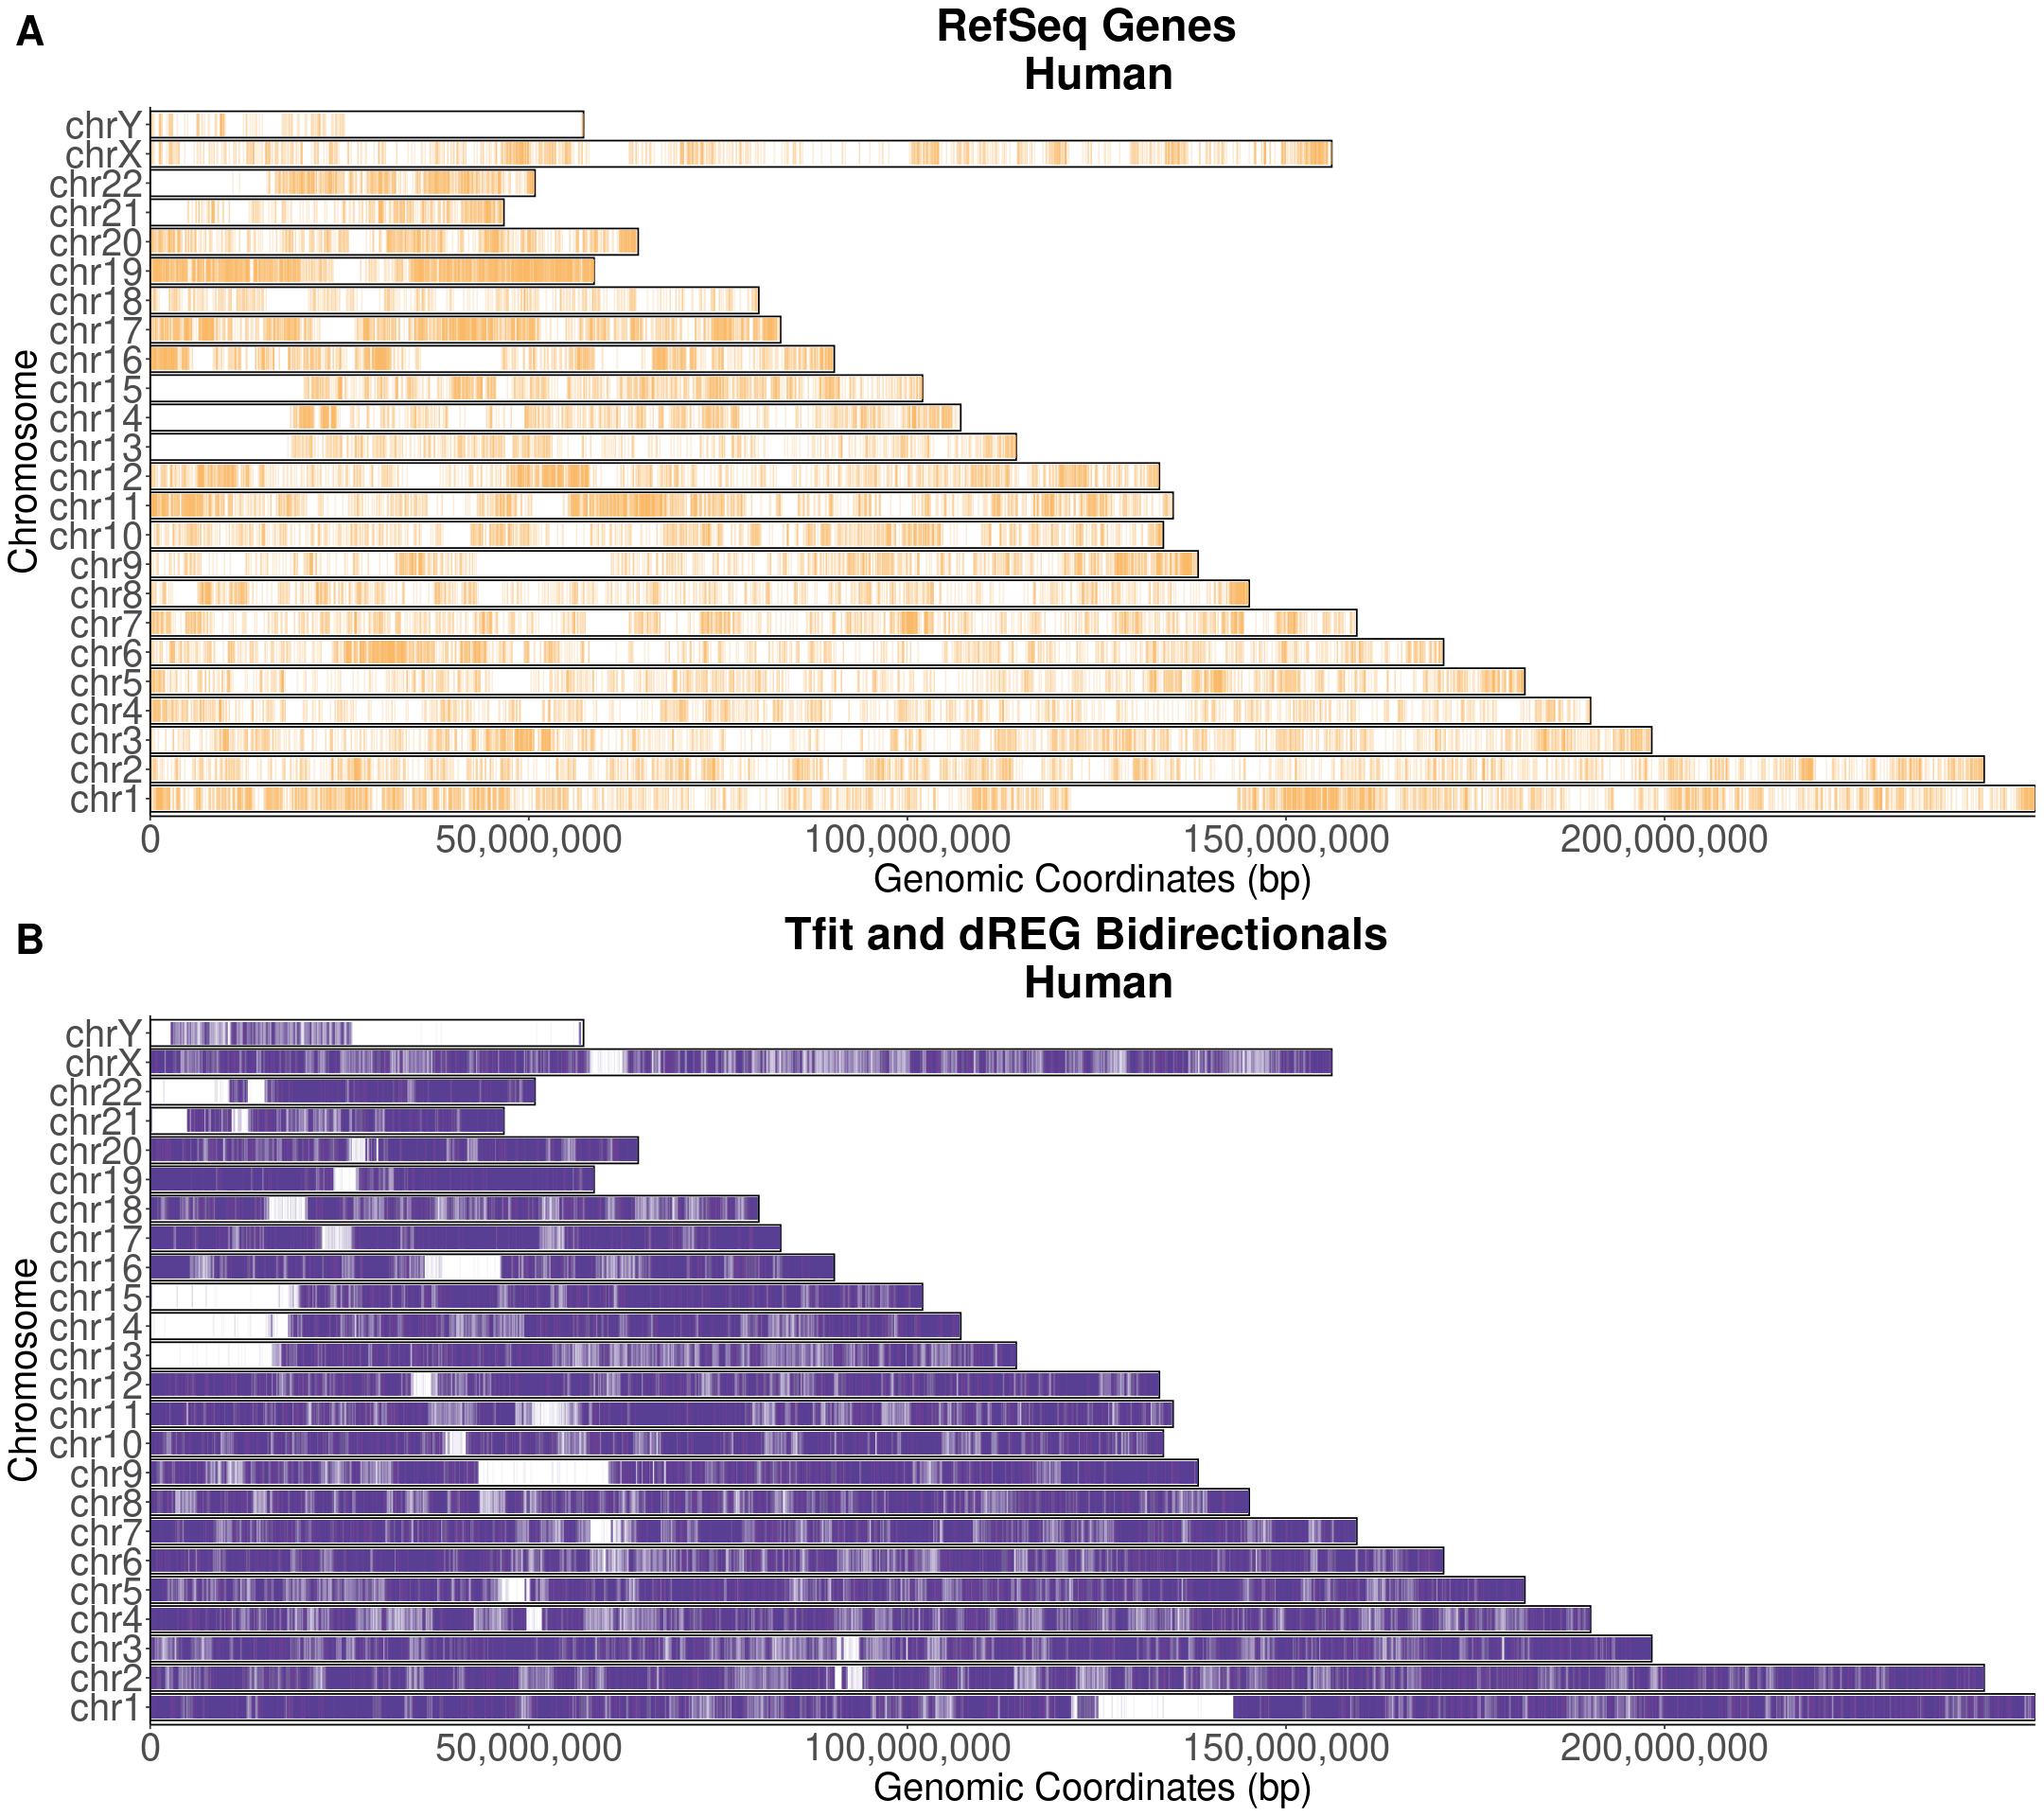

In [43]:
options(repr.plot.width=18, repr.plot.height=16)
hg38_refseq_bidirs_plot <- cowplot::plot_grid(hg38_refseq_plot,
                                              hg38_bidirs_plot,
                                              labels = c('A', 'B'),
                                              label_size = 26,
                                              ncol = 1)
hg38_refseq_bidirs_plot

In [44]:
ggsave(hg38_refseq_bidirs_plot, width = 18, height = 16,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/hg38_refseq_bidirs_genome.png", 
       bg = "transparent")

### Mouse

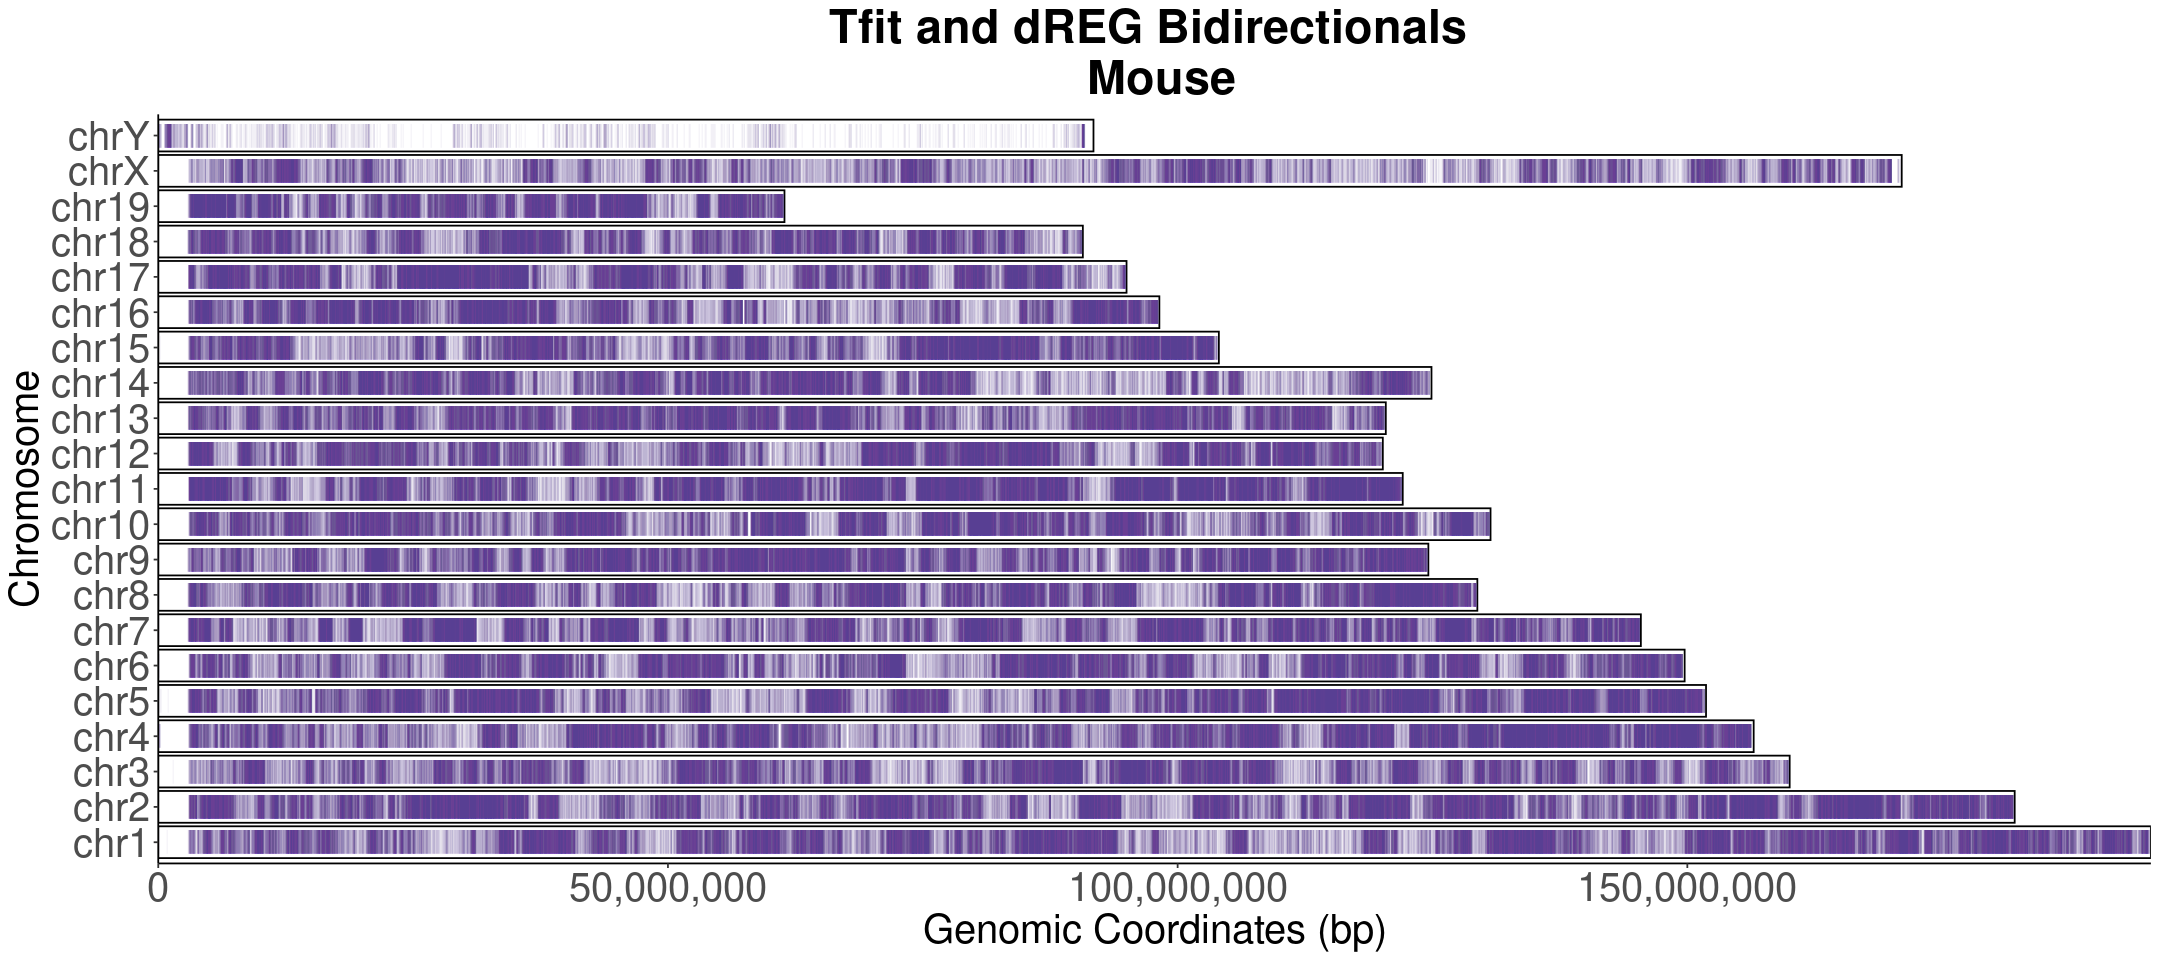

In [45]:
options(repr.plot.width=18, repr.plot.height=8)

mm10_bidirs_plot <- ggplot(data=mm10_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = mm10_bidirs,
           aes(y = V1, x = V2), 
           shape=124, 
           color='#5e3c99',#'orange',
           size=5, 
           alpha=0.05) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
ggtitle("Tfit and dREG Bidirectionals \n Mouse") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

mm10_bidirs_plot

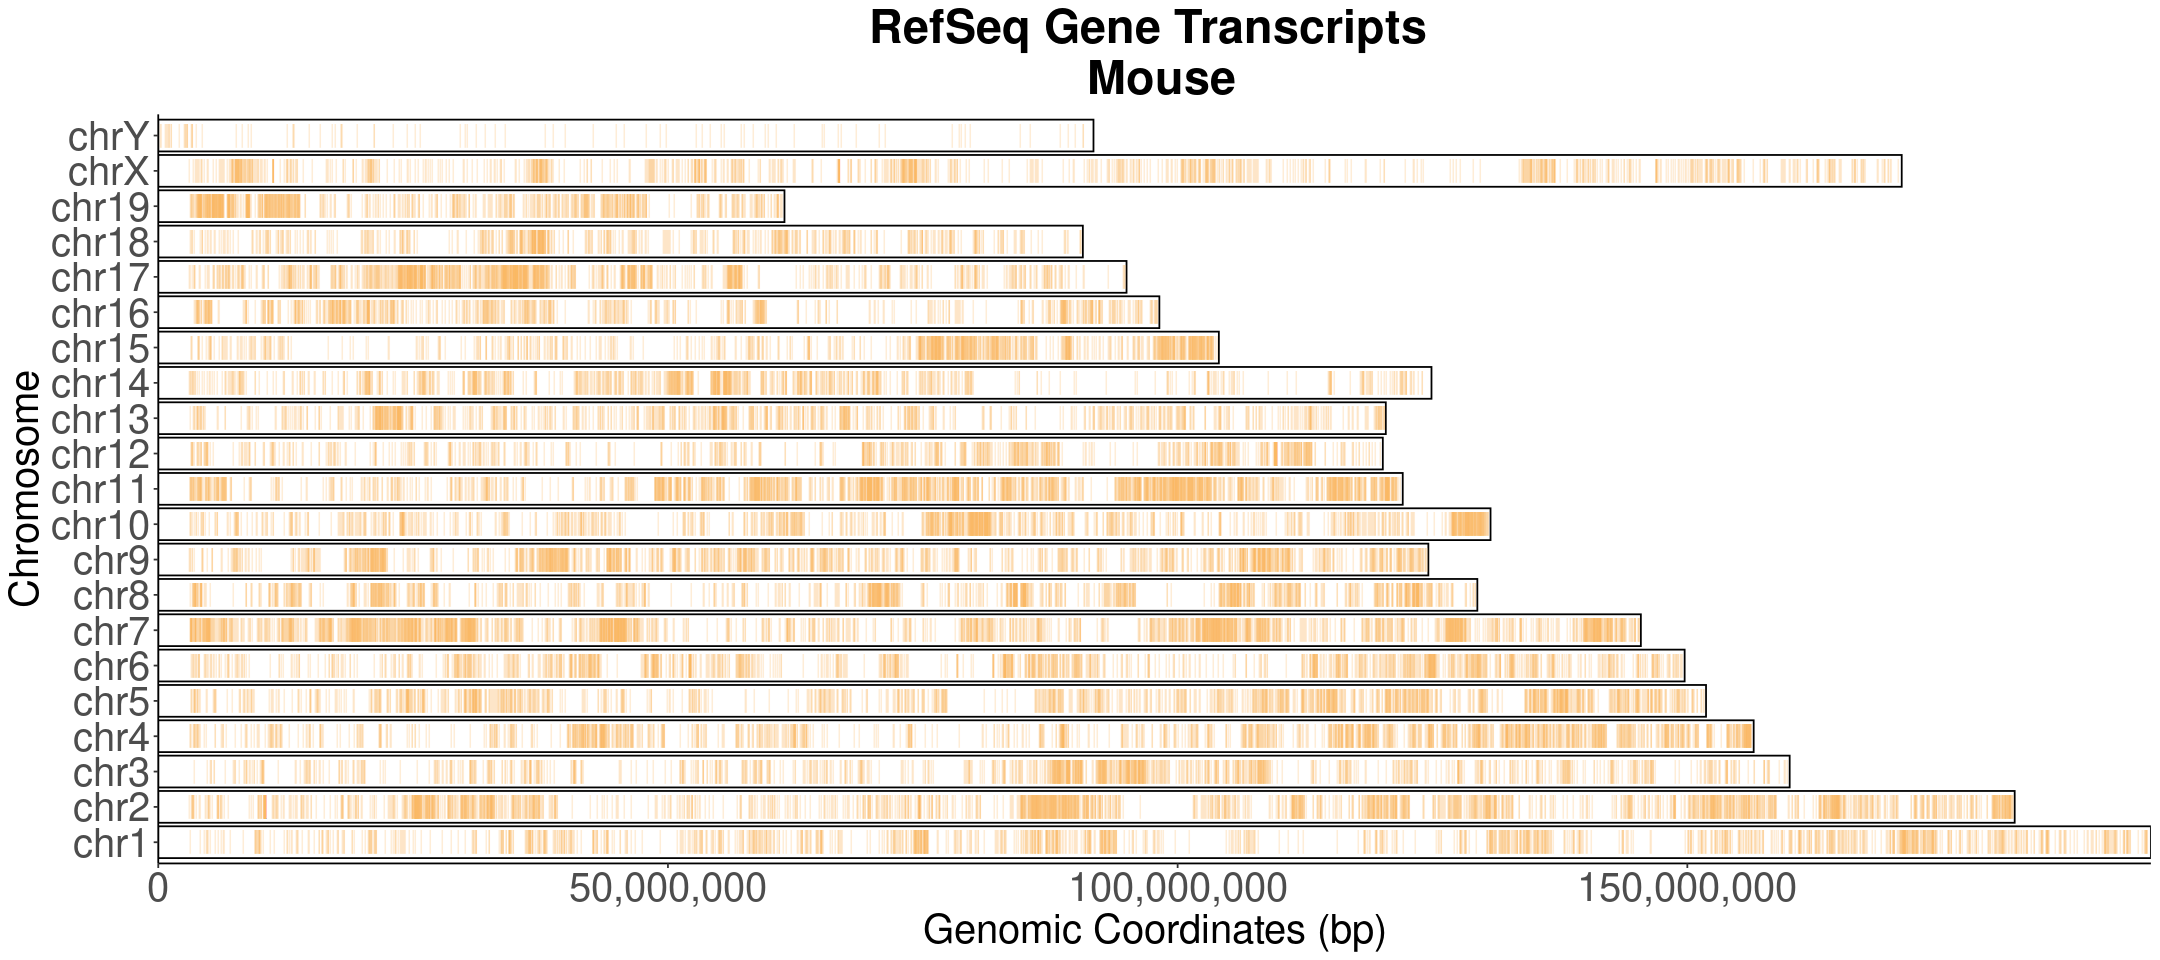

In [46]:
options(repr.plot.width=18, repr.plot.height=8)

mm10_refseq_plot <- ggplot(data=mm10_chroms, 
       aes(y=chrs, x=V2)) +
geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = mm10_refseq_chr,
           aes(y = V1, x = V2), 
           shape=124, 
           color='#fdb863',#'gray40',
           size=5, 
           alpha=0.25) +
xlab("Genomic Coordinates (bp)") +
ylab("Chromosome") +
#ggtitle("Tfit Bidirectionals \n mm10 RefSeq Gene Transcripts") +
ggtitle("RefSeq Gene Transcripts \n Mouse") +
theme_classic() +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "bold",
                               size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 18))

mm10_refseq_plot

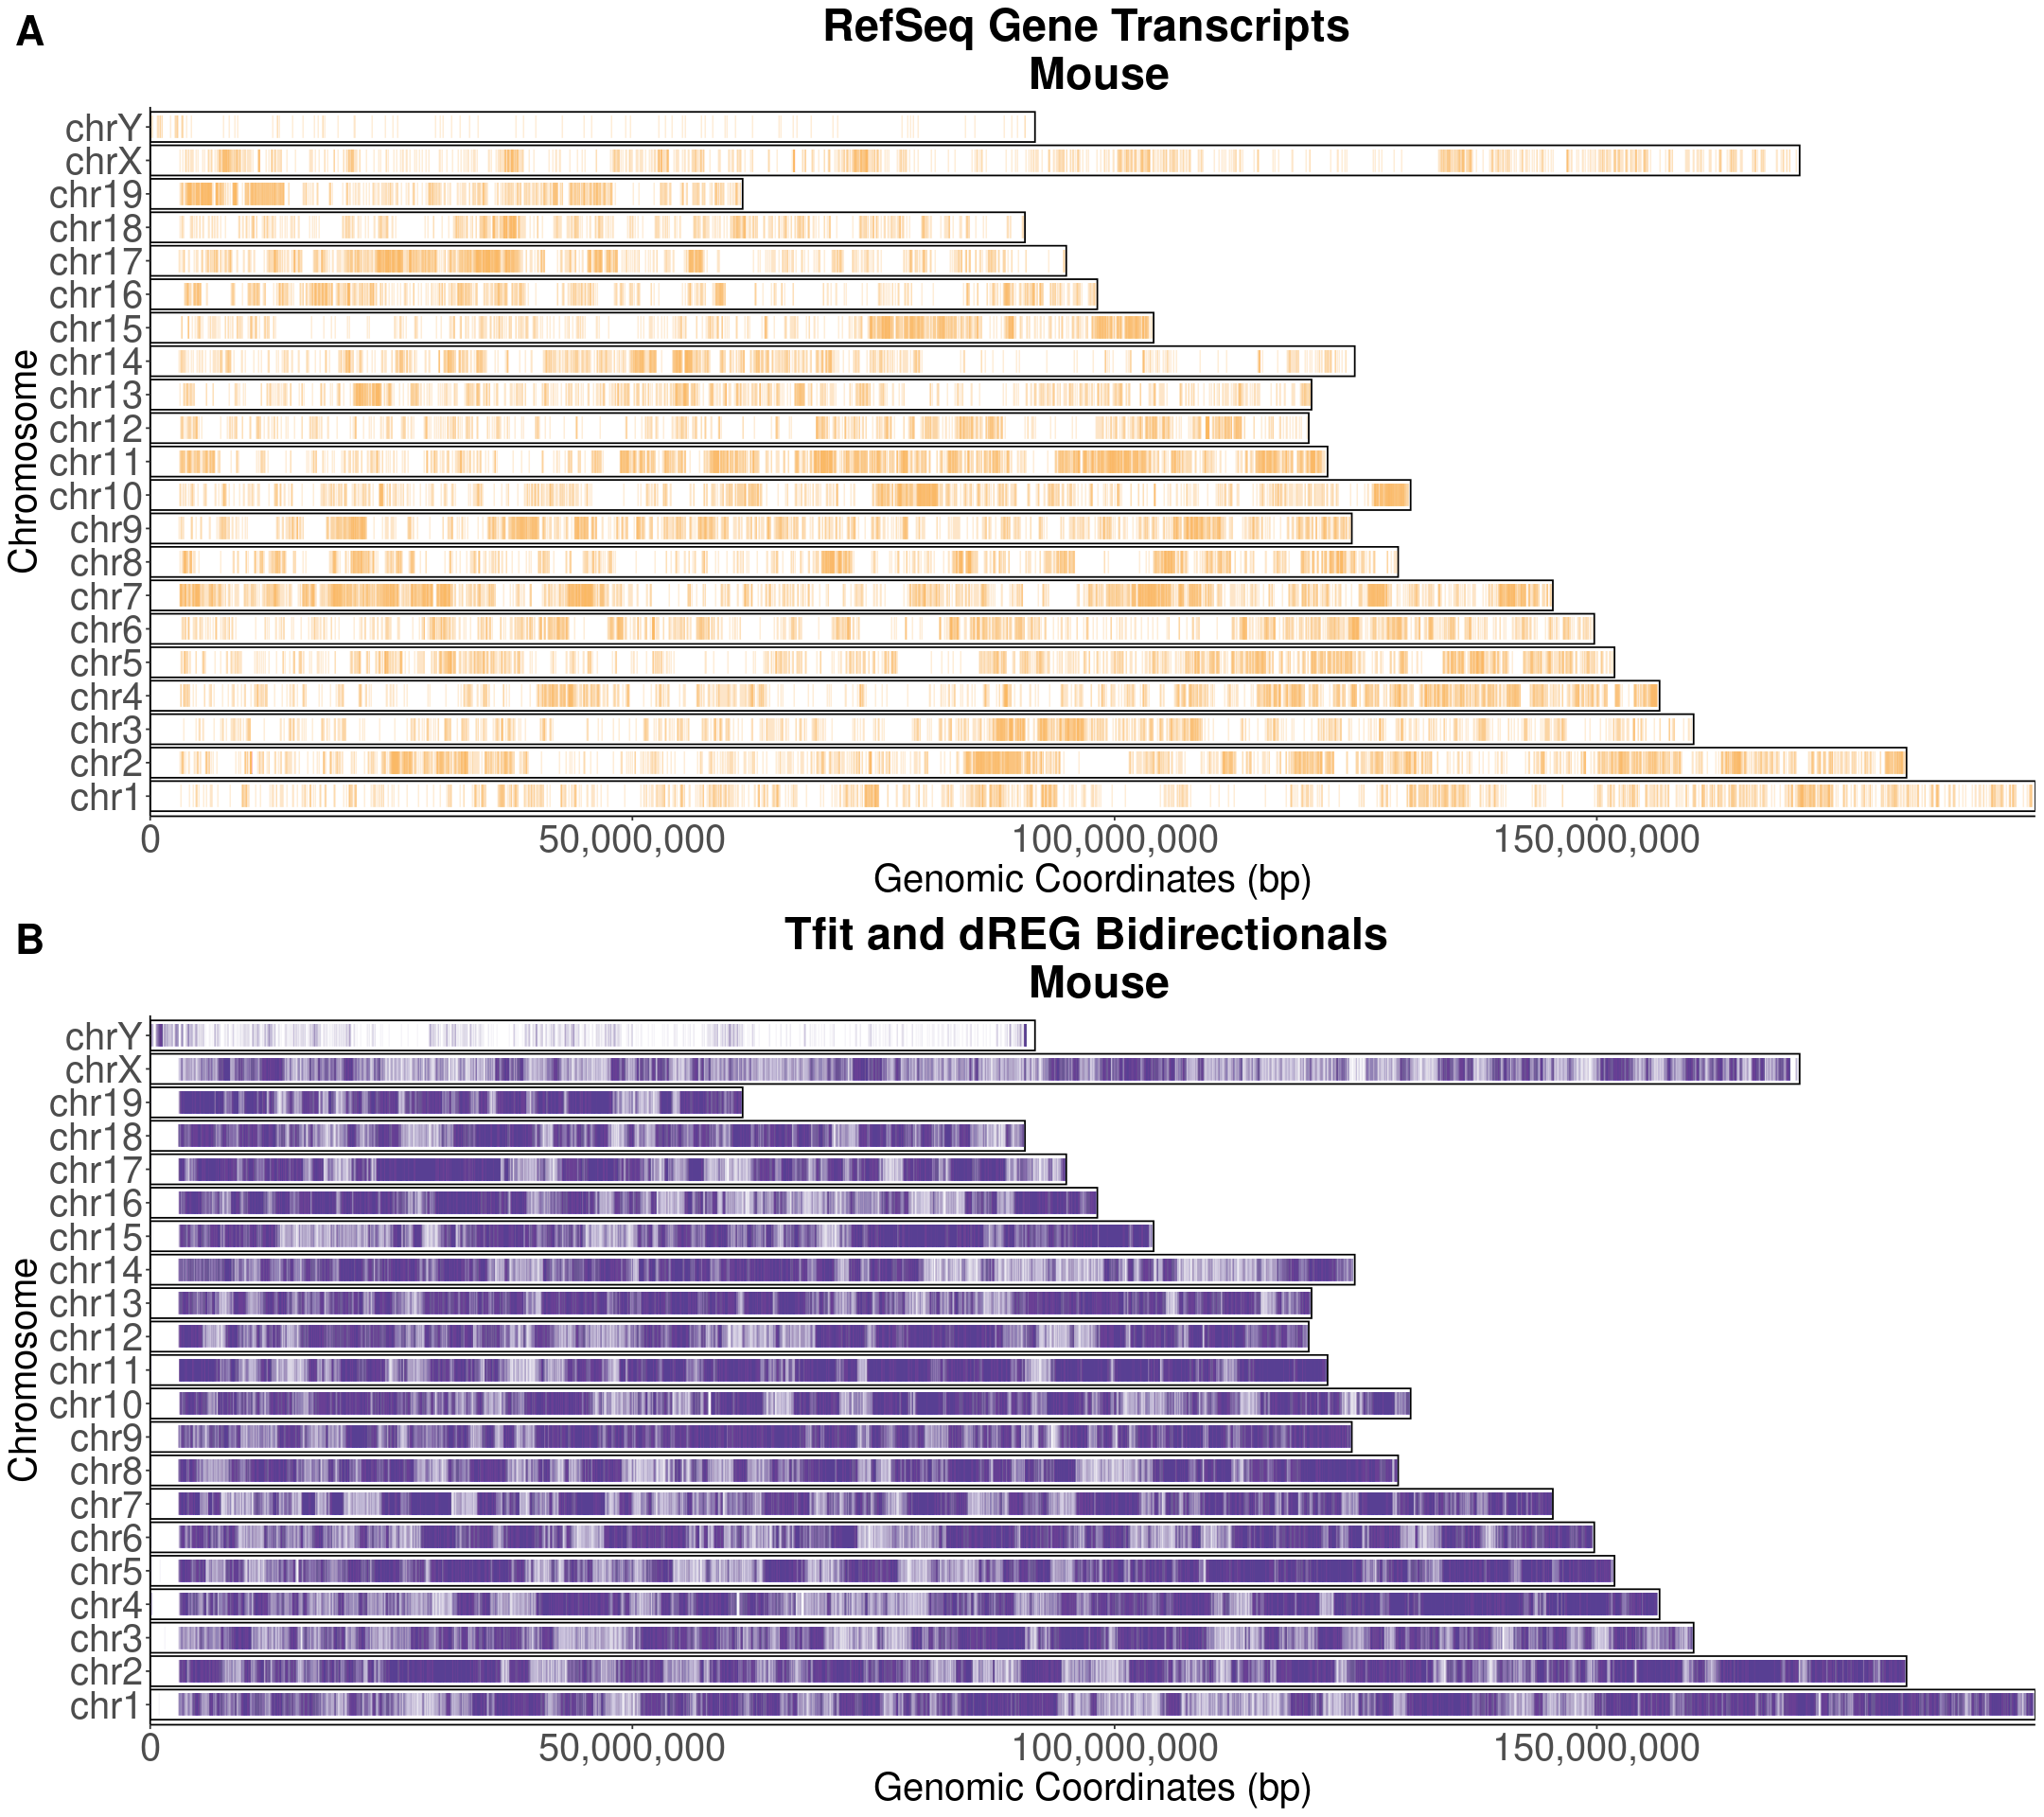

In [47]:
options(repr.plot.width=18, repr.plot.height=16)
mm10_refseq_bidirs_plot <- cowplot::plot_grid(mm10_refseq_plot,
                                              mm10_bidirs_plot,
                                              labels = c('A', 'B'),
                                              label_size = 26,
                                              ncol = 1)
mm10_refseq_bidirs_plot

In [48]:
ggsave(mm10_refseq_bidirs_plot, width = 18, height = 16,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/mm10_refseq_bidirs_genome.png", 
       bg = "transparent")

# Session Information

In [49]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] VennDiagram_1.7.3   futile.logger_1.4.3 ggvenn_0.1.9       
[4] dplyr_1.0.10        scales_1.2.1        cowplot_1.1.1      
[7] ggplot2_3.3.6       data.table_1.14.2  

loaded via a namespace (and not attached):
 [1] RColorBrewer_1.1-3   formatR_1.12         pillar_1.8.1        
 [4] compiler_3.6.0       futile.opti